In [1]:
from pysides.gen_fluxes import gen_Snu_arr
from astropy.io import fits
import astropy.units as u
import scipy.constants as cst
import numpy as np
from astropy import wcs
from astropy.stats import gaussian_fwhm_to_sigma
import astropy.convolution as conv
import datetime
from astropy.table import Table
import pickle
from copy import deepcopy
import os
from IPython import embed
import pickle
import matplotlib.pyplot as plt
from set_k import *
from powspec import power_spectral_density
from pysides.gen_fluxes import gen_Snu_arr
from pysides.load_params import *


In [4]:
cube_prop_dict = pickle.load( open('OUTPUT_TIM_CUBES_FROM_UCHUU/cubeprop.p', 'rb'))
w = cube_prop_dict['w']

cat = Table.read('OUTPUT_TIM_CUBES_FROM_UCHUU/cat_1deg2_1000GHz_dnu4GHz_CII.fits')
freq = 1000
cat = cat.to_pandas()

line = 'CII_de_Looze'

res = (cube_prop_dict['w'].wcs.cdelt[0]*u.deg).to(u.arcsec)
pixel_sr = ((res**2)).to(u.sr) #solid angle of the pixel in sr 

The transmission inside the +- dnu range is: 0.5000171847230238 - 0.9999999943062543
Relat. diff between sums in maps and cats: 1.218159807816181 1.2181582879981585


/home/mvancuyck/anaconda3/envs/camb/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


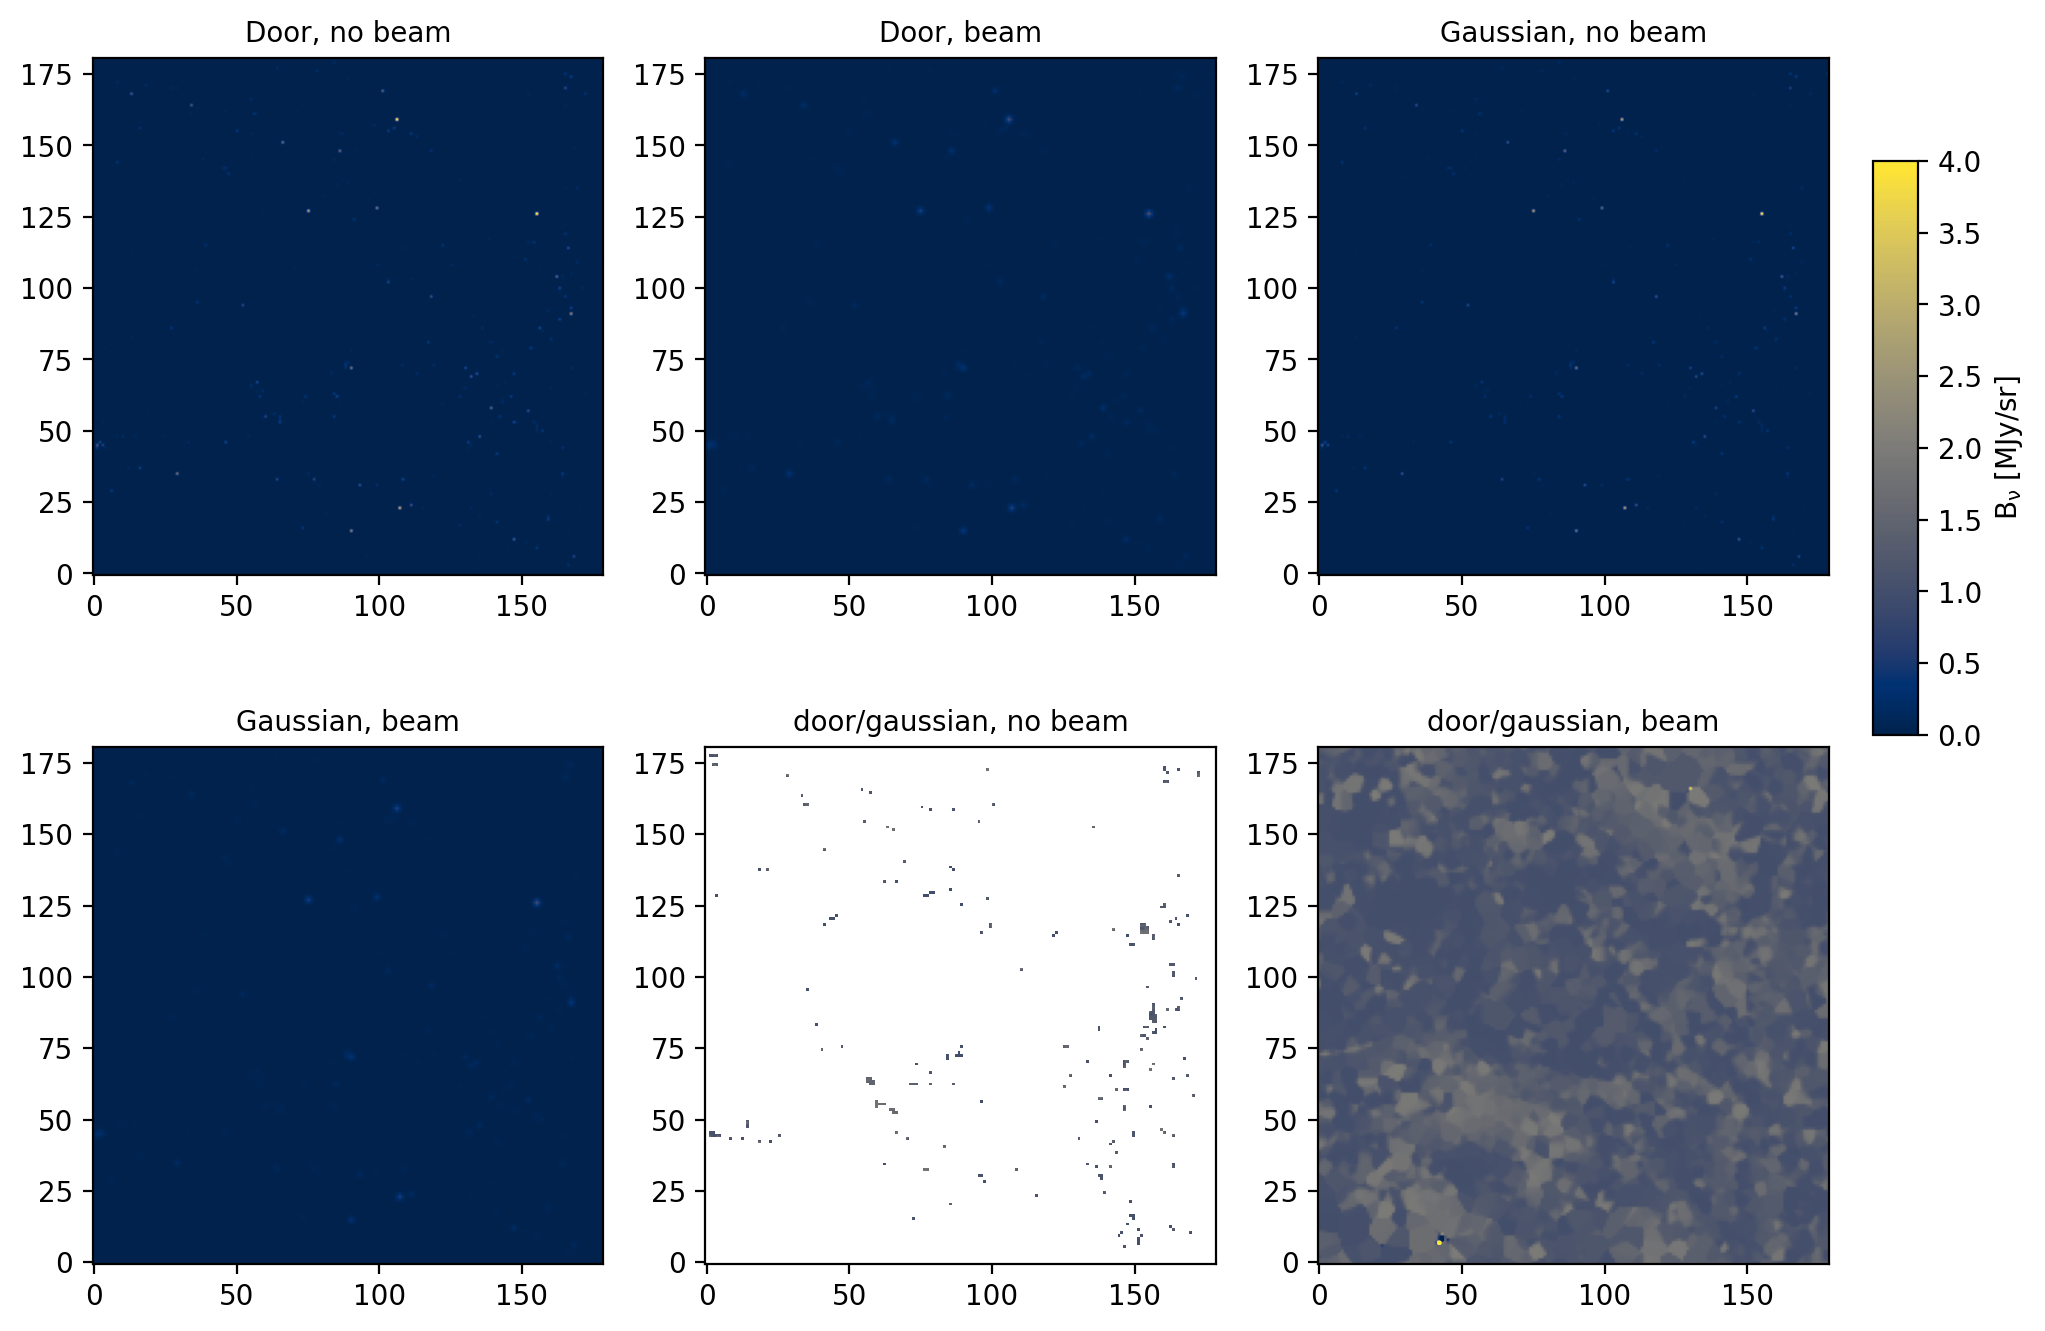

In [5]:
freq_obs = 1900.54 / (1 + cat['redshift']) #GHz
#freq_channel = np.round(freq_obs,0).astype(int) #GHz
nudelt = abs(cube_prop_dict['w'].wcs.cdelt[2]) * 1e-9 #GHz
vdelt = (cst.c * 1e-3) * nudelt / freq_obs #km/s
Snu = cat['I'+line] / vdelt  #Jy

fwhm = ((1.22 * cst.c) / (freq*1e9 * 1.9)) * u.rad
#print(freq, fwhm.to('arcsec'))
sigma = (fwhm * gaussian_fwhm_to_sigma).to(u.arcsec)
sigma_pix = sigma.value / res.value  #pixel
kernel_channel = conv.Gaussian2DKernel(x_stddev=sigma_pix, x_size=cube_prop_dict['shape'][1])
kernel_channel.normalize(mode="peak")

x, y = w.celestial.wcs_world2pix(cat['ra'] , cat['dec'] , 0)
CII_nobeam_Jypix, edges = np.histogramdd(sample=(y, x), bins=(cube_prop_dict['y_edges'], cube_prop_dict['x_edges']), weights=Snu)
CII_MJy_sr = CII_nobeam_Jypix / pixel_sr * 1.e-6 
CII_MJy_sr_smoothed = conv.convolve_fft(CII_MJy_sr, kernel_channel, normalize_kernel=True, boundary="wrap")


fwhm = abs(cube_prop_dict['w'].wcs.cdelt[2]) * 1e-9
sigma = fwhm * gaussian_fwhm_to_sigma # Convert FWHM to sigma ##!!!!
transmission = np.exp(-((freq_obs - freq) ** 2) / (2 * (sigma)**2))
Snu_transmitted = Snu * transmission 
CII_nobeam_Jypix_transmitted, edges = np.histogramdd(sample=(y, x), bins=(cube_prop_dict['y_edges'], cube_prop_dict['x_edges']), weights=Snu_transmitted)
CII_MJy_sr_transmitted = CII_nobeam_Jypix_transmitted / pixel_sr * 1.e-6 
CII_MJy_sr_smoothed_transmitted = conv.convolve_fft(CII_MJy_sr_transmitted, kernel_channel, normalize_kernel=True, boundary="wrap")


print('The transmission inside the +- dnu range is:',transmission.min(),'-', transmission.max())
print('Relat. diff between sums in maps and cats:', np.sum(Snu)/np.sum(Snu_transmitted), np.sum(CII_MJy_sr)/np.sum(CII_MJy_sr_transmitted))
factor = np.sum(Snu)/np.sum(Snu_transmitted)

BS=10; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); lw=1; mk=5; elw=1
fig, axs = plt.subplots(2, 3, figsize=(11.2,8.2), dpi = 200,)
axs = np.ravel(axs)
for iax, (axs, im,title) in enumerate(zip(axs,(CII_MJy_sr,CII_MJy_sr_smoothed,CII_MJy_sr_transmitted,CII_MJy_sr_smoothed_transmitted, CII_MJy_sr/CII_MJy_sr_transmitted,CII_MJy_sr_smoothed/CII_MJy_sr_smoothed_transmitted),
                                     ('Door, no beam', 'Door, beam', 'Gaussian, no beam', 'Gaussian, beam','door/gaussian, no beam', 'door/gaussian, beam'))):
    im = axs.imshow(im.value, origin='lower',  vmin=0,vmax=4, cmap='cividis')

    axs.set_title(title)

# Create colorbar for cividis colormap
cbar_ax_cividis = fig.add_axes([0.92, 0.45, 0.02, 0.35])  # [left, bottom, width, height]
cbar_cividis = fig.colorbar(im, cax=cbar_ax_cividis)
cbar_cividis.set_label('$\\rm B_{\\nu}$ [MJy/sr]')

#fig.tight_layout(rect=[0, 0, 0.9, 0.8])  # Adjust the layout to make space for the colorbars
fig.savefig(f'slices.pdf', bbox_inches='tight', pad_inches=0)
plt.show()
        

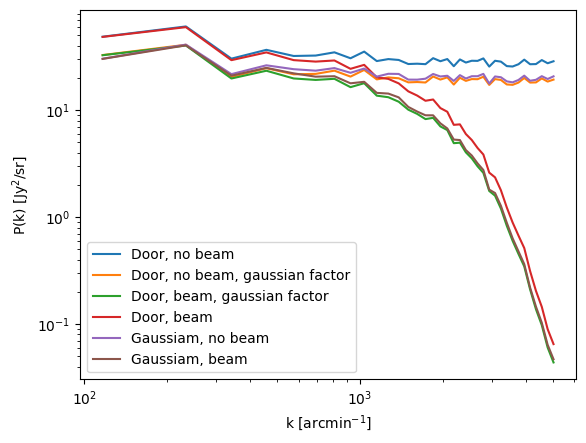

In [6]:
k_nyquist, k_min, k_bin_width, k_bin_tab, k_out, k_map = set_k_infos(CII_MJy_sr.shape[1], CII_MJy_sr.shape[0], res.to(u.rad), delta_k_over_k = 0.05)
pk, e =  power_spectral_density(CII_MJy_sr*u.Jy*1e6, res.to(u.rad), bins = k_bin_tab)
pk_smoothed, e =  power_spectral_density(CII_MJy_sr_smoothed*u.Jy*1e6, res.to(u.rad), bins = k_bin_tab)
pkg, e = power_spectral_density(CII_MJy_sr_transmitted*u.Jy*1e6, res.to(u.rad), bins = k_bin_tab)
pkgs, e = power_spectral_density(CII_MJy_sr_smoothed_transmitted*u.Jy*1e6, res.to(u.rad), bins = k_bin_tab)

plt.loglog(k_out, pk, label='Door, no beam')
plt.loglog(k_out, pk/factor**2, label='Door, no beam, gaussian factor')
plt.loglog(k_out, pk_smoothed/factor**2, label='Door, beam, gaussian factor')
plt.loglog(k_out, pk_smoothed, label='Door, beam')
plt.loglog(k_out, pkg, label='Gaussiam, no beam' )
plt.loglog(k_out, pkgs, label='Gaussiam, beam' )
plt.xlabel('k [$\\rm arcmin^{-1}$]')
plt.ylabel('P(k) [$\\rm Jy^2/sr$]')
plt.legend()


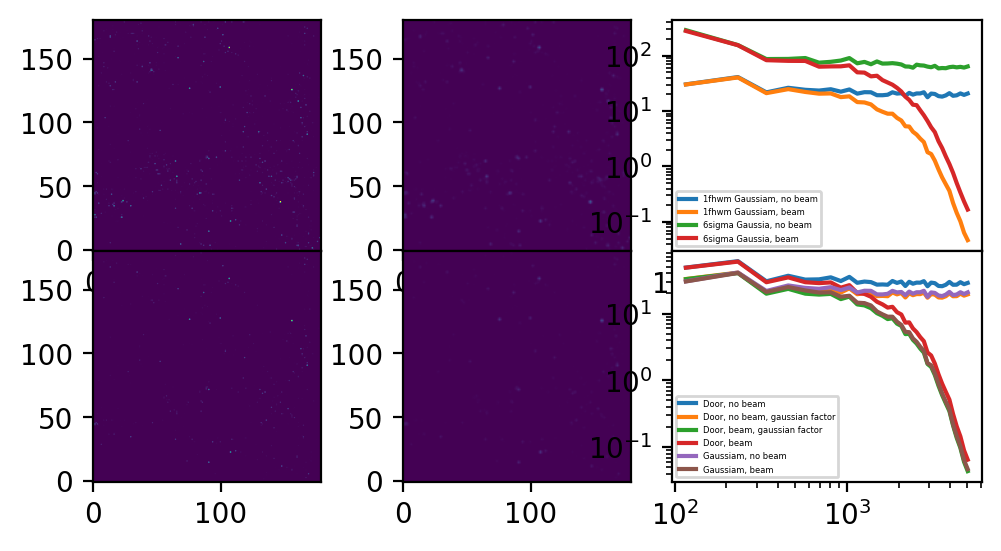

In [7]:
cat_wings = Table.read('cat_1deg2_1000GHz_dnu4GHz_3sigma_with_wings_CII.fits')
cat_wings = cat_wings.to_pandas()

freq_obs = 1900.54 / (1 + cat_wings['redshift']) #GHz
#freq_channel = np.round(freq_obs,0).astype(int) #GHz
nudelt = abs(cube_prop_dict['w'].wcs.cdelt[2]) * 1e-9 #GHz
vdelt = (cst.c * 1e-3) * nudelt / freq_obs #km/s
Snu = cat_wings['I'+line] / vdelt  #Jy
x, y = w.celestial.wcs_world2pix(cat_wings['ra'] , cat_wings['dec'] , 0)
CII_nobeam_MJysr_gaussian, edges = np.histogramdd(sample=(y, x), bins=(cube_prop_dict['y_edges'], cube_prop_dict['x_edges']), weights=Snu)
CII_nobeam_MJysr_gaussian /= pixel_sr.value*1e6
kernel_channel = conv.Gaussian2DKernel(x_stddev=sigma_pix, x_size=CII_nobeam_MJysr_gaussian.shape[0])
kernel_channel.normalize(mode="peak")
CII_smooth_MJysr_gaussian = conv.convolve_fft(CII_nobeam_MJysr_gaussian, kernel_channel, normalize_kernel=True, boundary="wrap")

pktg, e = power_spectral_density(CII_nobeam_MJysr_gaussian*u.Jy*1e6, res.to(u.rad), bins = k_bin_tab)
pktgs, e = power_spectral_density(CII_smooth_MJysr_gaussian*u.Jy*1e6, res.to(u.rad), bins = k_bin_tab)

#-----
cat_wingsonly = Table.read('cat_1deg2_1000GHz_dnu4GHz_3sigma_with_wings_CII.fits')
cat_wingsonly = cat_wingsonly.to_pandas()

freq_obs = 1900.54 / (1 + cat_wingsonly['redshift']) #GHz
#freq_channel = np.round(freq_obs,0).astype(int) #GHz
nudelt = abs(cube_prop_dict['w'].wcs.cdelt[2]) * 1e-9 #GHz
vdelt = (cst.c * 1e-3) * nudelt / freq_obs #km/s
Snu = cat_wingsonly['I'+line] / vdelt  #Jy
x, y = w.celestial.wcs_world2pix(cat_wingsonly['ra'] , cat_wingsonly['dec'] , 0)
CII_nobeam_MJysr_gaussian, edges = np.histogramdd(sample=(y, x), bins=(cube_prop_dict['y_edges'], cube_prop_dict['x_edges']), weights=Snu)
CII_nobeam_MJysr_gaussian /= pixel_sr.value*1e6
kernel_channel = conv.Gaussian2DKernel(x_stddev=sigma_pix, x_size=CII_nobeam_MJysr_gaussian.shape[0])
kernel_channel.normalize(mode="peak")
CII_smooth_MJysr_gaussian = conv.convolve_fft(CII_nobeam_MJysr_gaussian, kernel_channel, normalize_kernel=True, boundary="wrap")
#-----


fig, axs = plt.subplots(2,3,figsize=(6,3), dpi=200, )
axs[0,0].imshow(CII_nobeam_MJysr_gaussian, origin = 'lower', vmin=0, vmax=4)
axs[0,1].imshow(CII_smooth_MJysr_gaussian, origin = 'lower', vmin=0, vmax=4)
axs[1,0].imshow(CII_MJy_sr_transmitted.value, origin = 'lower', vmin=0, vmax=4)
axs[1,1].imshow(CII_MJy_sr_smoothed_transmitted.value, origin = 'lower', vmin=0, vmax=4)
fig.subplots_adjust(hspace=0, wspace=0)


axs[0,2].loglog(k_out, pkg, label='1fhwm Gaussiam, no beam' )
axs[0,2].loglog(k_out, pkgs, label='1fhwm Gaussiam, beam' )
axs[0,2].loglog(k_out, pktg, label='6sigma Gaussia, no beam')
axs[0,2].loglog(k_out, pktgs, label='6sigma Gaussia, beam')
axs[0,2].legend(fontsize=3)

axs[1,2].loglog(k_out, pk, label='Door, no beam')
axs[1,2].loglog(k_out, pk/factor**2, label='Door, no beam, gaussian factor')
axs[1,2].loglog(k_out, pk_smoothed/factor**2, label='Door, beam, gaussian factor')
axs[1,2].loglog(k_out, pk_smoothed, label='Door, beam')
axs[1,2].loglog(k_out, pkg, label='Gaussiam, no beam' )
axs[1,2].loglog(k_out, pkgs, label='Gaussiam, beam' )
axs[1,2].legend(fontsize=3)


In [11]:
cube_prop_dict = pickle.load( open('cubeprop.p', 'rb'))
w = cube_prop_dict['w']

cat = Table.read('pySIDES_from_uchuu_tile_0_1deg_x_1deg.fits')
cat = cat.to_pandas()

res = (cube_prop_dict['w'].wcs.cdelt[0]*u.deg).to(u.arcsec)
pixel_sr = ((res**2)).to(u.sr).value #solid angle of the pixel in sr

#-------- Doorstep original cube--------------------- 
freq_obs = np.asarray(1900.54 / (1 + cat['redshift']) )#GHz
channel = np.asarray(cube_prop_dict['w'].swapaxes(0, 2).sub(1).wcs_world2pix(freq_obs*1e9, 0))[0] 
nudelt = abs(cube_prop_dict['w'].wcs.cdelt[2]) * 1e-9 #GHz
vdelt = (cst.c * 1e-3) * nudelt / freq_obs #km/s
S = np.asarray(cat['I'+line] / vdelt )
CII_nobeam_Jypix, edges = np.histogramdd(sample=(channel, cube_prop_dict['pos'][0], cube_prop_dict['pos'][1]), bins=(cube_prop_dict['z_edges'], cube_prop_dict['y_edges'], cube_prop_dict['x_edges']), weights=S)
CII_nobeam_Jysr = CII_nobeam_Jypix / pixel_sr
#----------------------------------------------------
#----------Gaussian beamed cube----------------------
z = np.arange(0,cube_prop_dict['shape'][0],1)
w = cube_prop_dict['w']
freq_list = w.swapaxes(0, 2).sub(1).wcs_pix2world(z, 0)[0] / 1e9
# Compute N-sigma range for each channel, N is given by params['freq_width_in_sigma']
fwhm = w.wcs.cdelt[2] / 1e9
sigma = fwhm * gaussian_fwhm_to_sigma
transmission = np.exp(-((freq_obs[:, None] - freq_list) ** 2) / (2 * (sigma)**2))
Snu_transmitted = S[:, np.newaxis] * transmission 
CII_nobeam_Jypix_gaussian = []
for f in range(0, cube_prop_dict['shape'][0]):      
    row = Snu_transmitted[:,f] #Jy/pix
    histo, y_edges, x_edges = np.histogram2d(cube_prop_dict['pos'][0], cube_prop_dict['pos'][1], bins=(cube_prop_dict['y_edges'], cube_prop_dict['x_edges']), weights=row)
    CII_nobeam_Jypix_gaussian.append(histo) #Jy/pix, no beam
CII_nobeam_Jysr_gaussian = CII_nobeam_Jypix_gaussian / pixel_sr
#----------------------------------------------------


KeyboardInterrupt: 

In [6]:
path = '/home/mvancuyck/Desktop/LIM_and_foregrounds/cubes/'
cube_door=fits.getdata(path+'pySIDES_from_uchuu_TIM_tile0_highz_1.414deg_1.414deg_res20arcsec_dnu4.0GHz_CII_de_Looze_nobeam_MJy_sr.fits')
cube_gaus=fits.getdata(path+'pySIDES_from_uchuu_gaussian_TIM_tile0_highz_1.414deg_1.414deg_res20arcsec_dnu4.0GHz_minus0.0GHz_forfwhm_CII_de_Looze_nobeam_MJy_sr.fits')

k_nyquist, k_min, k_bin_width, k_bin_tab, k_out, k_map = set_k_infos(cube_prop_dict['shape'][1], cube_prop_dict['shape'][0], res.to(u.rad), delta_k_over_k = 0.05)
for f in range(0, 13):      
    pk, e  =  power_spectral_density(cube_door[f,:,:]*1e6, res.to(u.rad), bins = k_bin_tab)
    plt.loglog(k_out.to(1/u.arcmin), pk, ls = ':')
    pkg, e =  power_spectral_density(cube_gaus[f,:,:]*1e6, res.to(u.rad), bins = k_bin_tab)
    plt.loglog(k_out.to(1/u.arcmin), pkg, c='k')
'''
plt.figure()
for f in range(0, 13):      
    pk, e  =  power_spectral_density(cube_door[f,:,:]*1e6, res.to(u.rad), bins = k_bin_tab)
    pkg, e =  power_spectral_density(cube_gaus[f,:,:]*1e6, res.to(u.rad), bins = k_bin_tab)
    plt.loglog(k_out.to(1/u.arcmin), pkg/pk, c='k')
    
'''

FileNotFoundError: [Errno 2] No such file or directory: '.pySIDES_from_uchuu_TIM_tile0_highz_1.414deg_1.414deg_res20arcsec_dnu4.0GHz_CII_de_Looze_nobeam_MJy_sr.fits'

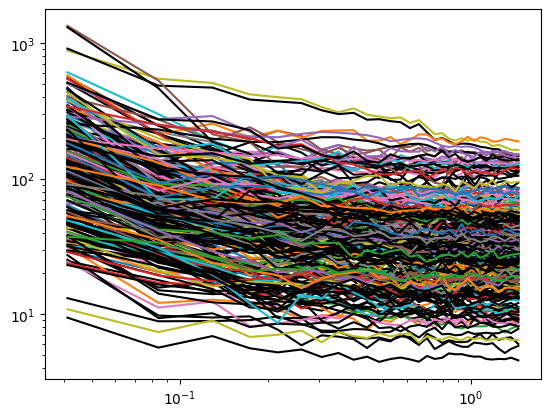

In [169]:


k_nyquist, k_min, k_bin_width, k_bin_tab, k_out, k_map = set_k_infos(cube_prop_dict['shape'][1], cube_prop_dict['shape'][0], res.to(u.rad), delta_k_over_k = 0.05)
for f in range(0, cube_prop_dict['shape'][0]):      
    pk, e =  power_spectral_density(CII_nobeam_Jysr[f,:,:], res.to(u.rad), bins = k_bin_tab)
    plt.loglog(k_out.to(1/u.arcmin), pk)
       
    pk, e =  power_spectral_density(CII_nobeam_Jysr_gaussian[f,:,:], res.to(u.rad), bins = k_bin_tab)
    plt.loglog(k_out.to(1/u.arcmin), pk, c='k')